#  Application of ISODATA Model using IRIS Dataset
# Classification of Iris flower. Each row of the table represents species and dimensions of its botanical parts, sepal and petal, in centimeters.

In [41]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Use ISODATA Model
class ISODATA:
    def __init__(self, 
                 K_initial=6,
                 max_iterations=50,
                 min_cluster_size=5,
                 max_variance=1.0,
                 min_cluster_distance=1.0,
                 split_offset=0.5):
        
        self.K_initial = K_initial
        self.max_iterations = max_iterations
        self.min_cluster_size = min_cluster_size
        self.max_variance = max_variance
        self.min_cluster_distance = min_cluster_distance
        self.split_offset = split_offset

    def fit(self, X):
        n_samples, n_features = X.shape
        
        # Step 1: Initialize centroids randomly
        indices = np.random.choice(n_samples, self.K_initial, replace=False)
        centroids = X[indices]

        for iteration in range(self.max_iterations):

            # Step 2: Assign points
            distances = pairwise_distances(X, centroids)
            labels = np.argmin(distances, axis=1)

            # Build clusters
            clusters = []
            for k in range(len(centroids)):
                cluster_points = X[labels == k]
                if len(cluster_points) > 0:
                    clusters.append(cluster_points)
                else:
                    clusters.append(np.empty((0, n_features)))

            # Step 3: Remove small clusters
            clusters = [c for c in clusters if len(c) >= self.min_cluster_size]

            # Recompute centroids
            centroids = np.array([np.mean(c, axis=0) for c in clusters])

            # Step 5: Split clusters with high variance
            new_centroids = []
            for c, centroid in zip(clusters, centroids):
                variances = np.var(c, axis=0)

                if np.max(variances) > self.max_variance:
                    # Split cluster
                    offset_vector = self.split_offset * np.sqrt(variances)
                    new_centroids.append(centroid + offset_vector)
                    new_centroids.append(centroid - offset_vector)
                else:
                    new_centroids.append(centroid)

            centroids = np.array(new_centroids)

            # Step 6: Merge clusters that are close
            merged = set()
            final_centroids = []

            for i in range(len(centroids)):
                if i in merged:
                    continue

                for j in range(i + 1, len(centroids)):
                    if j in merged:
                        continue

                    dist = np.linalg.norm(centroids[i] - centroids[j])
                    if dist < self.min_cluster_distance:
                        merged.add(j)
                        # Merge as average
                        merged_centroid = (centroids[i] + centroids[j]) / 2
                        centroids[i] = merged_centroid

                final_centroids.append(centroids[i])

            centroids = np.array(final_centroids)

        # Save model
        self.centroids = centroids
        self.labels_ = np.argmin(pairwise_distances(X, centroids), axis=1)
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.centroids)
        return np.argmin(distances, axis=1)


In [42]:
# Load dataset
iris = load_iris()
X = iris.data

# Run ISODATA
model = ISODATA(
    K_initial=6,
    max_iterations=40,
    min_cluster_size=5,
    max_variance=0.8,
    min_cluster_distance=1.0,
    split_offset=0.4
)

model.fit(X)

print("Final number of clusters:", len(model.centroids))
print("Cluster labels:", np.unique(model.labels_))
print("Centroids:\n", model.centroids)


Final number of clusters: 2
Cluster labels: [0 1]
Centroids:
 [[5.00566038 3.36981132 1.56037736 0.29056604]
 [6.30103093 2.88659794 4.95876289 1.69587629]]


In [43]:
# ---------------------------------------------------------
# Train–Test Split
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


# ---------------------------------------------------------
# Helper function for evaluating ISODATA
# (returns Silhouette score)
# ---------------------------------------------------------
def evaluate_isodata(X, K_initial, max_iterations,
                     min_cluster_size, max_variance,
                     min_cluster_distance, split_offset):
    
    model = ISODATA(
        K_initial=K_initial,
        max_iterations=max_iterations,
        min_cluster_size=min_cluster_size,
        max_variance=max_variance,
        min_cluster_distance=min_cluster_distance,
        split_offset=split_offset
    )
    
    model.fit(X)
    
    # Need at least 2 labels for Silhouette score
    if len(np.unique(model.labels_)) < 2:
        return -1
    
    return silhouette_score(X, model.labels_)


# ---------------------------------------------------------
# K-fold Cross-Validation (manual, since ISODATA is custom)
# ---------------------------------------------------------
from sklearn.model_selection import KFold

def cross_validate_isodata(X, params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]

        score = evaluate_isodata(
            X_train_cv,
            params["K_initial"],
            params["max_iterations"],
            params["min_cluster_size"],
            params["max_variance"],
            params["min_cluster_distance"],
            params["split_offset"]
        )

        scores.append(score)

    return np.mean(scores)



Train size: (120, 4)
Test size: (30, 4)


In [44]:

# ---------------------------------------------------------
# GRID SEARCH for ISODATA hyperparameters
# (manual search because ISODATA is not sklearn-compatible)
# ---------------------------------------------------------
from itertools import product

param_grid = {
    "K_initial": [4, 6, 8],
    "max_iterations": [30, 50],
    "min_cluster_size": [3, 5],
    "max_variance": [0.5, 0.8, 1.2],
    "min_cluster_distance": [0.8, 1.0],
    "split_offset": [0.3, 0.4]
}

# Build all combinations
param_combinations = list(product(
    param_grid["K_initial"],
    param_grid["max_iterations"],
    param_grid["min_cluster_size"],
    param_grid["max_variance"],
    param_grid["min_cluster_distance"],
    param_grid["split_offset"]
))

best_score = -1
best_params = None

print(f"Total combinations: {len(param_combinations)}")

for combo in param_combinations:
    params = {
        "K_initial": combo[0],
        "max_iterations": combo[1],
        "min_cluster_size": combo[2],
        "max_variance": combo[3],
        "min_cluster_distance": combo[4],
        "split_offset": combo[5],
    }

    score = cross_validate_isodata(X_train, params, n_splits=5)

    if score > best_score:
        best_score = score
        best_params = params

    print(f"Params: {params}, Score: {score:.4f}")

print("\nBest Parameters:")
print(best_params)
print("Best CV Silhouette Score:", best_score)


Total combinations: 144
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.5, 'min_cluster_distance': 0.8, 'split_offset': 0.3}, Score: 0.5190
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.5, 'min_cluster_distance': 0.8, 'split_offset': 0.4}, Score: 0.5122
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.5, 'min_cluster_distance': 1.0, 'split_offset': 0.3}, Score: 0.5230
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.5, 'min_cluster_distance': 1.0, 'split_offset': 0.4}, Score: 0.5215
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.8, 'min_cluster_distance': 0.8, 'split_offset': 0.3}, Score: 0.5520
Params: {'K_initial': 4, 'max_iterations': 30, 'min_cluster_size': 3, 'max_variance': 0.8, 'min_cluster_distance': 0.8, 'split_offset': 0.4}, Score: 0.5050
Params: {'K_initial': 4, 'max_iterations

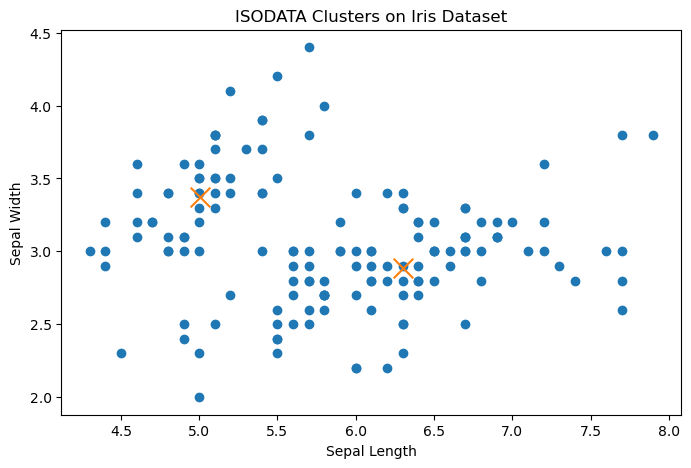

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.005660,3.369811,1.560377,0.290566
1,6.301031,2.886598,4.958763,1.695876


In [45]:
# Convert centroids to table
centroid_df = pd.DataFrame(model.centroids, columns=iris.feature_names)

# Plot clusters using first two features
plt.figure(figsize=(8,5))
plt.scatter(X[:,0], X[:,1])
plt.scatter(model.centroids[:,0], model.centroids[:,1], marker='x', s=200)
plt.title("ISODATA Clusters on Iris Dataset")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

centroid_df


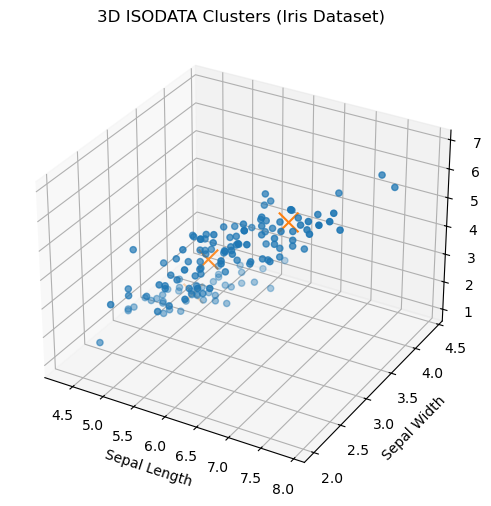

(   ISODATA_Frequency  KMeans_Frequency
 0                 39                50
 1                 50                62
 2                 61                38,
 0.5511916046195919,
 0.5528190123564095)

In [46]:
# Run ISODATA
iso = ISODATA(K_initial=6, max_iterations=40, min_cluster_size=5,
              max_variance=0.8, min_cluster_distance=1.0, split_offset=0.4)
iso.fit(X)

# Run KMeans
kmeans = KMeans(n_clusters=len(iso.centroids), n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Silhouette scores
silhouette_iso = silhouette_score(X, iso.labels_)
silhouette_kmeans = silhouette_score(X, kmeans_labels)

# Frequency tables
iso_freq = pd.Series(iso.labels_).value_counts().sort_index()
kmeans_freq = pd.Series(kmeans_labels).value_counts().sort_index()

# 3D Plot for ISODATA
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
ax.scatter(iso.centroids[:,0], iso.centroids[:,1], iso.centroids[:,2], marker='x', s=200)
ax.set_title("3D ISODATA Clusters (Iris Dataset)")
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_zlabel("Petal Length")
plt.show()

pd.DataFrame({
    "ISODATA_Frequency": iso_freq,
    "KMeans_Frequency": kmeans_freq
}), silhouette_iso, silhouette_kmeans
